In [ ]:
# Mapbox Token: 


In [ ]:
# # Please run this from conda env!  `eval "$($HOME/anaconda3/bin/conda shell.bash hook)"`


#%pip install cartopy
# # or
# !conda install --yes --prefix {sys.prefix}  -c conda-forge cartopy

# import subprocess, sys
# # cartopy image transforms require pykdtree or scipy
# subprocess.run([sys.executable, "-m", "pip", "install", "scipy", "-q"], check=True)

In [1]:


import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import cartopy
print(cartopy.__version__)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageOps
import IPython.display as display
import os, math, time
import cartopy.crs as ccrs
import cartopy 
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import os
import matplotlib.gridspec as gridspec
from PIL import ImageDraw
import matplotlib.ticker as mticker

import cartopy.io.img_tiles as cimgt

from matplotlib.image import imread
import numpy as np

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width*height

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import os
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import ImageFont

import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.image import imread

geoscents_home='/home/mattfel/geoscents/'


/home/mattfel/geoscents/.venv/bin/python
3.12.3 (main, Jan 22 2026, 20:57:42) [GCC 13.3.0]
sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
0.25.0


In [ ]:
def zoomLevel(coords):
    zoom_level = 6
    if (coords[3] - coords[2] < 5): #i.e. switzerland
        zoom_level = 10
    elif (coords[1] - coords[0] < 1.5): #i.e. vatican
        zoom_level = 17

    return zoom_level

def isPolar(coords):
    return coords[2] == -90 or coords[3] == 90


def basicFig(render, coords):
    
    zoom_level = zoomLevel(coords)
        
    split = coords[1] > 180 and coords[0] < 180 and not isPolar(coords)
    if (coords[0] < -180):
        print("please cross dateline at +180, not -180!")
        return
    
    my_dpi = 96
    cols = 1530 / my_dpi
    rows = 900 / my_dpi
    if (isPolar(coords)):
        # crop later
        rows = 1530 / my_dpi
    f = plt.figure(figsize=(cols, rows), dpi=my_dpi, frameon=False)
    if (split):
        spec = gridspec.GridSpec(ncols=2, nrows=1,width_ratios=[180 - coords[0],coords[1] - 180])

    plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0)

    projection = ccrs.Mercator(central_longitude=0)
    if (isPolar(coords)):
        lat = -90
        if (coords[3] == 90):
            lat = 90
        projection = ccrs.AzimuthalEquidistant(central_latitude=lat)
#         projection = ccrs.SouthPolarStereo()
    
    if (split):
        ax1 = f.add_subplot(spec[0],projection=projection)
        ax1.set_extent([coords[0], 180, coords[2], coords[3]], crs=ccrs.PlateCarree())
        ax2 = f.add_subplot(spec[1],projection=projection)
        ax2.set_extent([-180, coords[1] - 360, coords[2], coords[3]], crs=ccrs.PlateCarree())
    else:
        ax1 = plt.axes(projection=projection)
        ax1.set_extent(coords,  crs=ccrs.PlateCarree())
        ax2 = None
    ax1.set_axis_off()

    
    if (coords[2] != -90):
        coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='black',
                                                   facecolor='none')
        borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black',
                                                   facecolor='none')
        dispute = cfeature.NaturalEarthFeature('cultural', 'admin_0_breakaway_disputed_areas', '50m', edgecolor='red',
                                                   facecolor='none')
        ax1.add_feature(coastline)
        ax1.add_feature(borders, linewidth = 0.5, linestyle='-')
        ax1.add_feature(dispute, linewidth = 0.6, linestyle='-')
        
    if (split):
        ax2.add_feature(coastline)
        ax2.add_feature(borders, linewidth = 0.5, linestyle='-')
        ax2.add_feature(dispute, linewidth = 0.6, linestyle='-')

    if (render == 'terrain'):
        # Create a Stamen terrain background instance.
        ax1.add_feature(cartopy.feature.RIVERS, alpha = 0.8)
        ax1.add_feature(cartopy.feature.LAKES, alpha = 0.8)
        # terrain = cimgt.Stamen('terrain-background') #Stamen no longer supported
        terrain = cimgt.StadiaMapsTiles('5ab59f82-18b0-4fba-88b2-3dd5f11c0f53', 'stamen_terrain_background')
        ax1.add_image(terrain, zoom_level)
        if (split):
            ax2.add_feature(cartopy.feature.RIVERS, alpha = 0.8)
            ax2.add_feature(cartopy.feature.LAKES, alpha = 0.8)
            ax2.add_image(terrain, zoom_level)
            ax1.outline_patch.set_edgecolor('#99B3CC')
            ax2.outline_patch.set_edgecolor('#99B3CC')
    elif (render == 'satellite'):
        terrain = cimgt.GoogleTiles(style='satellite') # need cartopy 0.19 or 0.20 for cache=True)
        ax1.add_image(terrain, zoom_level)
        if (split):
            ax2.add_image(terrain, zoom_level)

    else:
       
        land_50m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='coral', facecolor='coral')
        ax1.add_feature(land_50m)
        # Get cartopy features for plotting
        ax1.add_feature(cfeature.LAKES, alpha = 0.4, color = 'aqua')
        rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
        ax1.add_feature(rivers, facecolor='None', edgecolor='aqua', alpha = 0.4)

        ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='aqua', facecolor='aqua'))

        borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black',
                                                   facecolor='none')
        ax1.add_feature(borders, linewidth = 0.5, linestyle='-')

        dispute = cfeature.NaturalEarthFeature('cultural', 'admin_0_breakaway_disputed_areas', '50m', edgecolor='red',
                                                   facecolor='none')
        ax1.add_feature(dispute, linewidth = 0.6, linestyle='-')
        coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='black',
                                               facecolor='none')
        ax1.add_feature(coastline)
        if (split):
            ax2.add_feature(land_50m)
            ax2.add_feature(cfeature.LAKES, alpha = 0.4, color = 'aqua')
            ax2.add_feature(rivers, facecolor='None', edgecolor='aqua', alpha = 0.4)
            ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='aqua', facecolor='aqua'))
            ax2.add_feature(borders, linewidth = 0.5, linestyle='-')
            ax2.add_feature(dispute, linewidth = 0.6, linestyle='-')
            ax2.add_feature(coastline)
            plt.gca().outline_patch.set_visible(False)
            
    if (isPolar(coords)):
        gl = ax1.gridlines(color='gray', alpha=0.5, linestyle='--', draw_labels=True, x_inline=True, y_inline=True)
        gl.xlocator = mticker.LinearLocator(19)
        if (coords[2] == -90):
            yticks = np.arange(70, 91, 10)
            gl.ylocator = mticker.FixedLocator(np.arange(coords[3], coords[2], -5))
        else:
            yticks = np.arange(70, 91, 10)
            gl.ylocator = mticker.FixedLocator(np.arange(coords[3], coords[2], -5))
        gl.xlabel_style = {'color': 'gray', 'alpha': 0.9, 'size': 11}
        gl.ylabel_style = {'color': 'gray', 'alpha': 0.9, 'size': 11}
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        # make the circle in the middle blend in
        center_color = 'aqua'
        if (render == "terrain" and coords[2] == -90):
            center_color = "#f0fbfb"
        elif (render == "satellite" and coords[2] == -90):
            center_color = "#bcbeca"
        elif (render == "terrain" and coords[3] == 90):
            center_color = "#99b3cc"
        elif (render == "satellite" and coords[3] == 90):
            center_color = "#283871"
        ax1.add_feature(cartopy.feature.LAND, color = center_color)
        ax1.add_feature(cartopy.feature.OCEAN, color = center_color)
    if (split):
        plt.subplots_adjust(wspace=-0.00001)


    return plt,ax1,ax2


def classic(coords, name):      
    plt,ax1,ax2 = basicFig('classic', coords)
    states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m', edgecolor='darkblue',
                                               facecolor='none')
    ax1.add_feature(states, linewidth = 0.1, linestyle='-')
    if (ax2):
        ax2.add_feature(states, linewidth = 0.1, linestyle='-')
    plt.savefig(geoscents_home + '/resources/maps/' + name + '_classic.png', transparent=True, pad_inches=0, bbox_inches='tight')
    img = Image.open(geoscents_home + '/resources/maps/' + name + '_classic.png')
    if (isPolar(coords)):
        # Antarctica starts out 1530x1530, needs to be cropped
        img = img.crop((0, 315, 1530, 1215))
        img.save(geoscents_home + '/resources/maps/' + name + '_classic.png')
    
    print(img)
    print("dims ok?")
    width_min = 1528
    width_max = 1532
    height_min = 898
    height_max = 902
    ok = img.size[0] > width_min and img.size[0] < width_max and img.size[1] > height_min and img.size[1] < height_max
    print(ok)
    print("target = " + str(width_min) + " to " + str(width_max) + " x " + str(height_min) + " to " + str(height_max))
    if (img.size[0] < width_min):
        print("too short horizontally. Make wider")
    if (img.size[0] > width_max):
        print("too long horizontally. Make shorter")
    if (img.size[1] < height_min):
        print("too short vertically. Make taller")
    if (img.size[1] > height_max):
        print("too tall vertically. Make wider")

    if (zoomLevel(coords) > 15):
        I1 = ImageDraw.Draw(img)

        # Add Text to an image
        I1.text((1300, 50), "Please use satellite map --->", fill=(255, 0, 0))
        img.save(geoscents_home + '/resources/maps/' + name + '_classic.png')
        img.show()
    
        
    return ok


def terrain(coords, name):
    plt,ax1,ax2 = basicFig("terrain", coords)
    states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m', edgecolor='darkblue',
                                               facecolor='none')
    ax1.add_feature(states, linewidth = 0.1, linestyle='-')
    if (ax2):
        ax2.add_feature(states, linewidth = 0.1, linestyle='-')
    plt.savefig(geoscents_home + '/resources/maps/' + name + '_terrain.png', transparent=True, pad_inches=0, bbox_inches='tight')
    # plt.show()
    img = Image.open(geoscents_home + '/resources/maps/' + name + '_terrain.png')
    # Also save as name.png for data visualizer    
    plt.savefig(geoscents_home + '/resources/maps/' + name + '.png', transparent=True, pad_inches=0, bbox_inches='tight')
    if (isPolar(coords)):
        # Antarctica starts out 1530x1530, needs to be cropped
        img = img.crop((0, 315, 1530, 1215))
        img.save(geoscents_home + '/resources/maps/' + name + '_terrain.png')
        img.save(geoscents_home + '/resources/maps/' + name + '.png')

    print(img)
    
    if (zoomLevel(coords) > 15):
        I1 = ImageDraw.Draw(img)

        # Add Text to an image
        I1.text((1300, 50), "Please use satellite map --->", fill=(255, 0, 0))
        img.save(geoscents_home + '/resources/maps/' + name + '_terrain.png')
        
    
def satellite(coords, name):
    plt,ax1,ax2 = basicFig('satellite', coords)
    states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', '10m', edgecolor='darkblue',
                                               facecolor='none')
    ax1.add_feature(states, linewidth = 0.25, linestyle='--')
    if (ax2):
        ax2.add_feature(states, linewidth = 0.25, linestyle='--')

    plt.savefig(geoscents_home + '/resources/maps/' + name + '_satellite.png', transparent=False, pad_inches=0, bbox_inches='tight')
    img = Image.open(geoscents_home + '/resources/maps/' + name + '_satellite.png')
    if (isPolar(coords)):
        # Antarctica starts out 1530x1530, needs to be cropped
        img = img.crop((0, 315, 1530, 1215))
        img.save(geoscents_home + '/resources/maps/' + name + '_satellite.png')

    if (zoomLevel(coords) > 15):
        # Also save as name.png for data visualizer
        plt.savefig(geoscents_home + '/resources/maps/' + name + '.png', transparent=True, pad_inches=0, bbox_inches='tight')
        print(img)
    

def basic_satellite(coords, name):
    # World
    plt,ax1,ax2 = basicFig('satellite', coords)
    # plt.show()
    plt.savefig(geoscents_home + '/resources/maps/' + name + '_satellite.png', transparent=True, pad_inches=0, bbox_inches='tight')


<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1530x899 at 0x734E7D62BE60>
dims ok?
True
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1530x899 at 0x734E7D525C40>


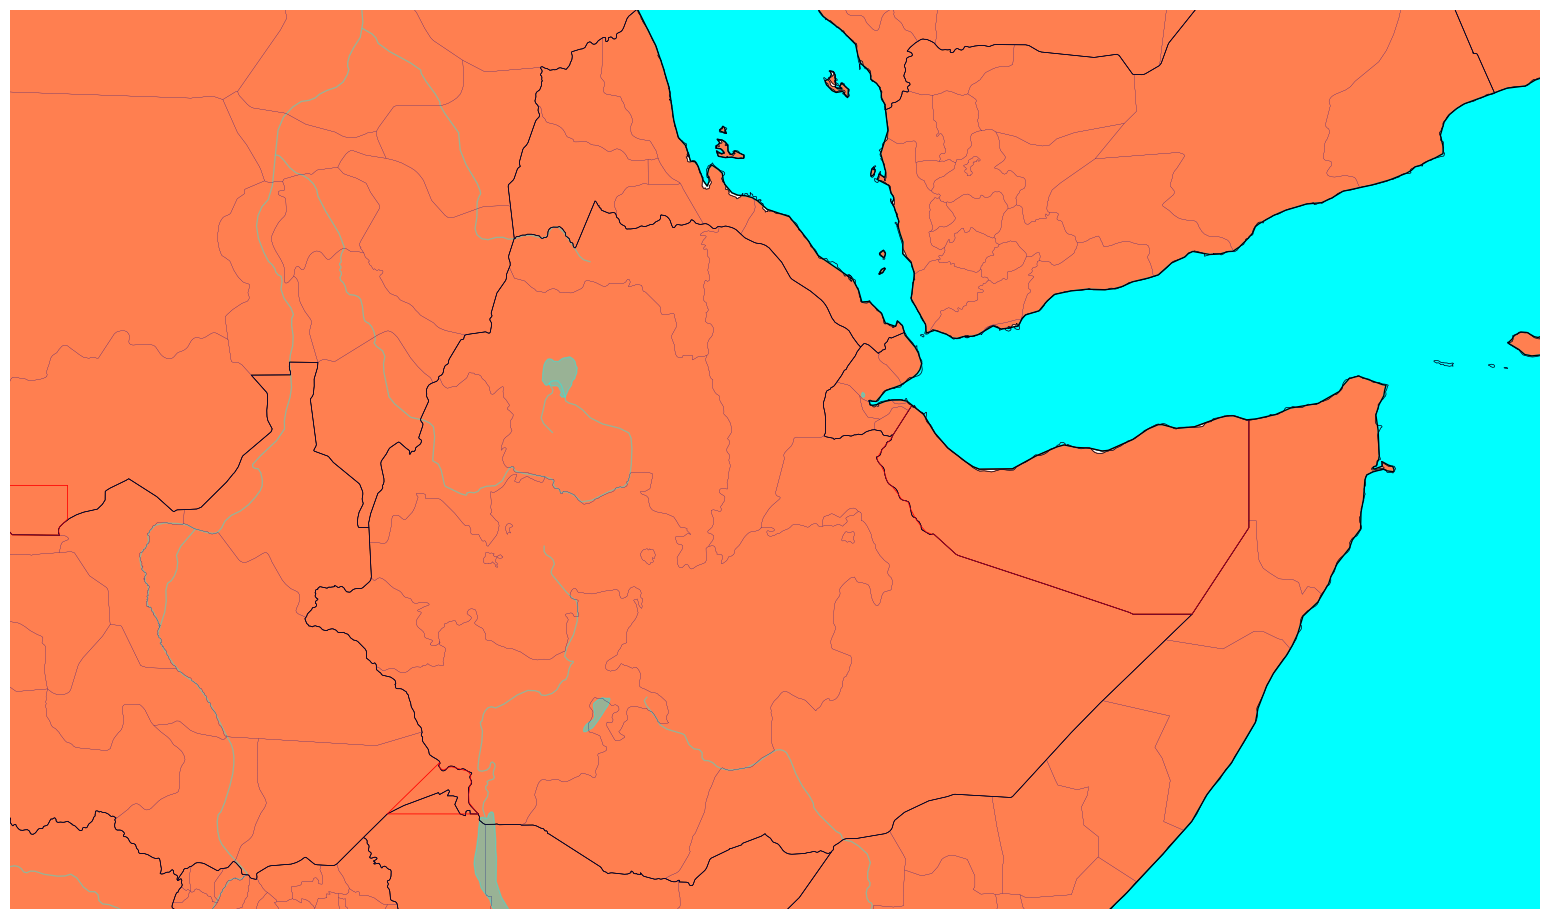

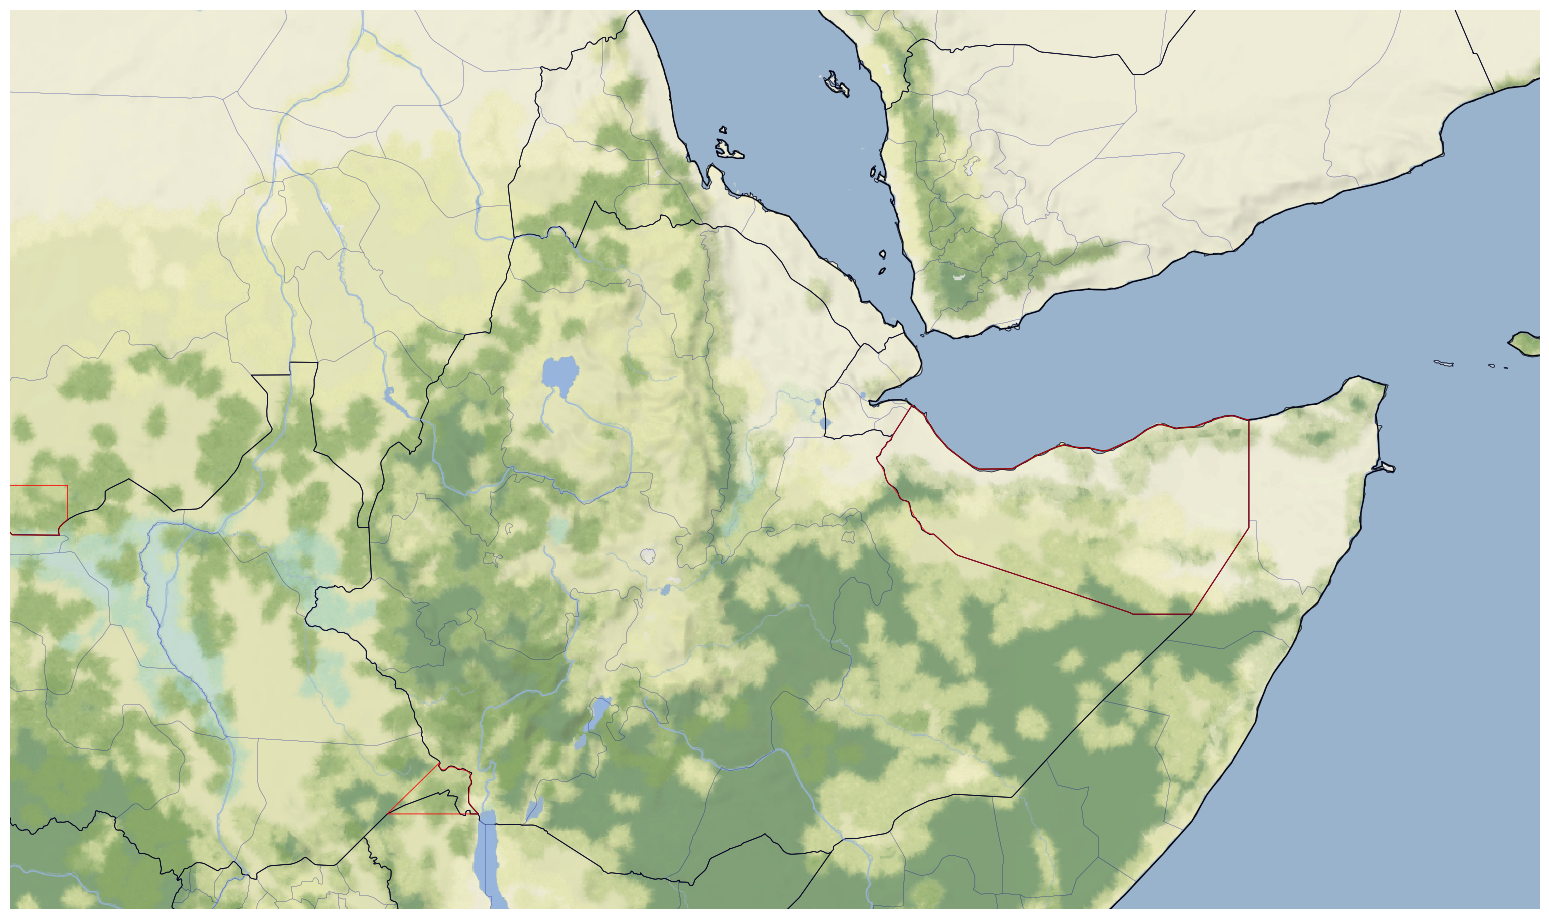

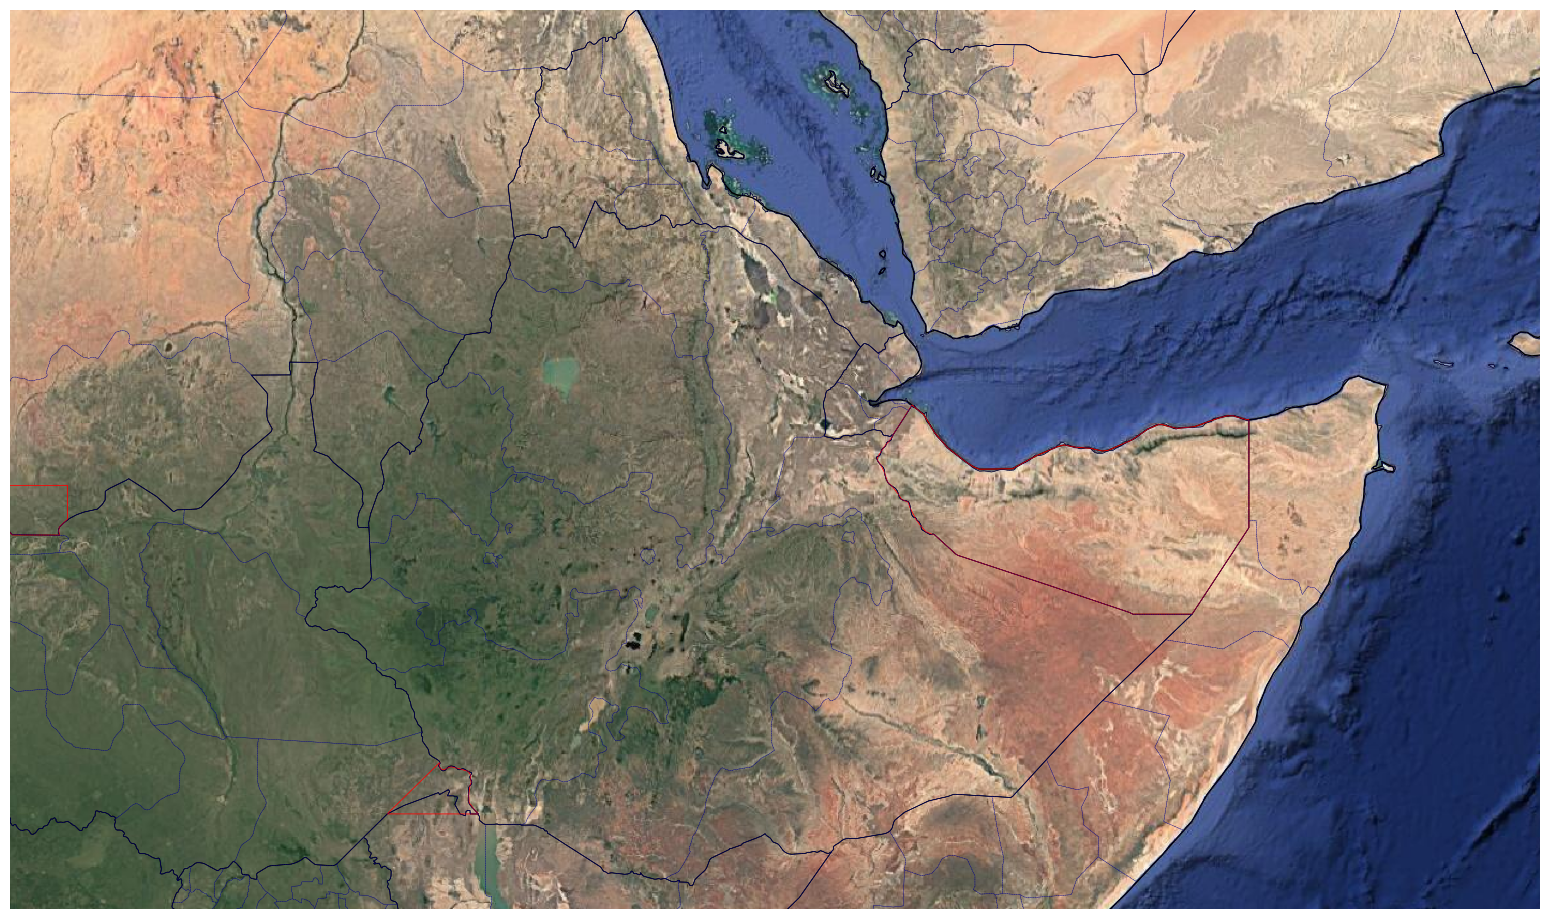

# Core maps

In [ ]:
coords = [-180, 180, -55.1, 81.05]
name = "trivia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

In [ ]:
coords = [-180, 180, -65.3, 77.2]
name = "world"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

In [ ]:
coords = [-60, 82, -36.3, 41]
name = "africa"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

In [ ]:
coords = [-141, -43, 10, 56]
name = "namerica"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

In [ ]:
coords = [-36.3, 52, 35, 66.3]
name = "europe"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

In [ ]:
coords = [-140, 17, -56, 24.1]
name = "samerica"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

In [ ]:
coords = [25, 158, -1, 61.05]
name = "asia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

In [ ]:
coords = [92, 252, -54.55, 28]
name = "oceania"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    basic_satellite(coords, name)

# Countries

In [ ]:
coords = [33.7, 52, 29, 38]
name = "mesopotamia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [18, 52.1, -15, 5]
name = "africangreatlakes"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [35, 51, 38, 45.06]
name = "caucuses"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [3.33, 18, 43, 49]
name = "alps"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-180, 180, 45, 90]
name = "arctic"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
# For some reason, -180 to 180 makes the image 896x900 and not a square...
coords = [-180, 180, -90, -52]
name = "antarctica"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-17.8, 23, 18, 39]
name = "algeria"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [8.15, 29, 48.5, 56]
name = "poland"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1530x899 at 0x734E7CE2ED50>
dims ok?
True
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1530x899 at 0x734E7C1127E0>


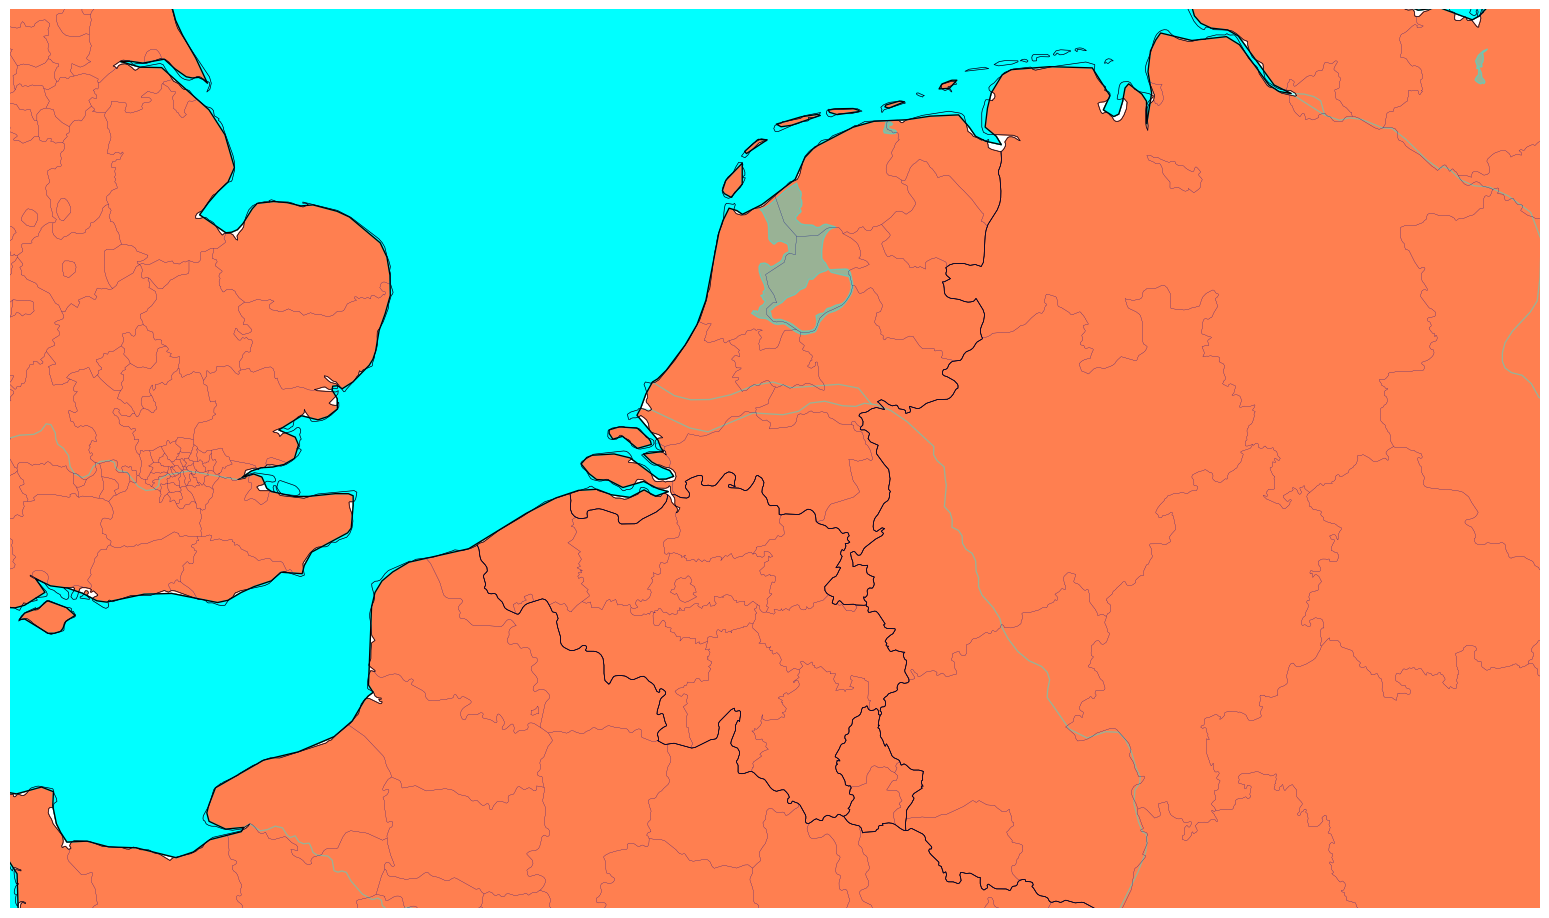

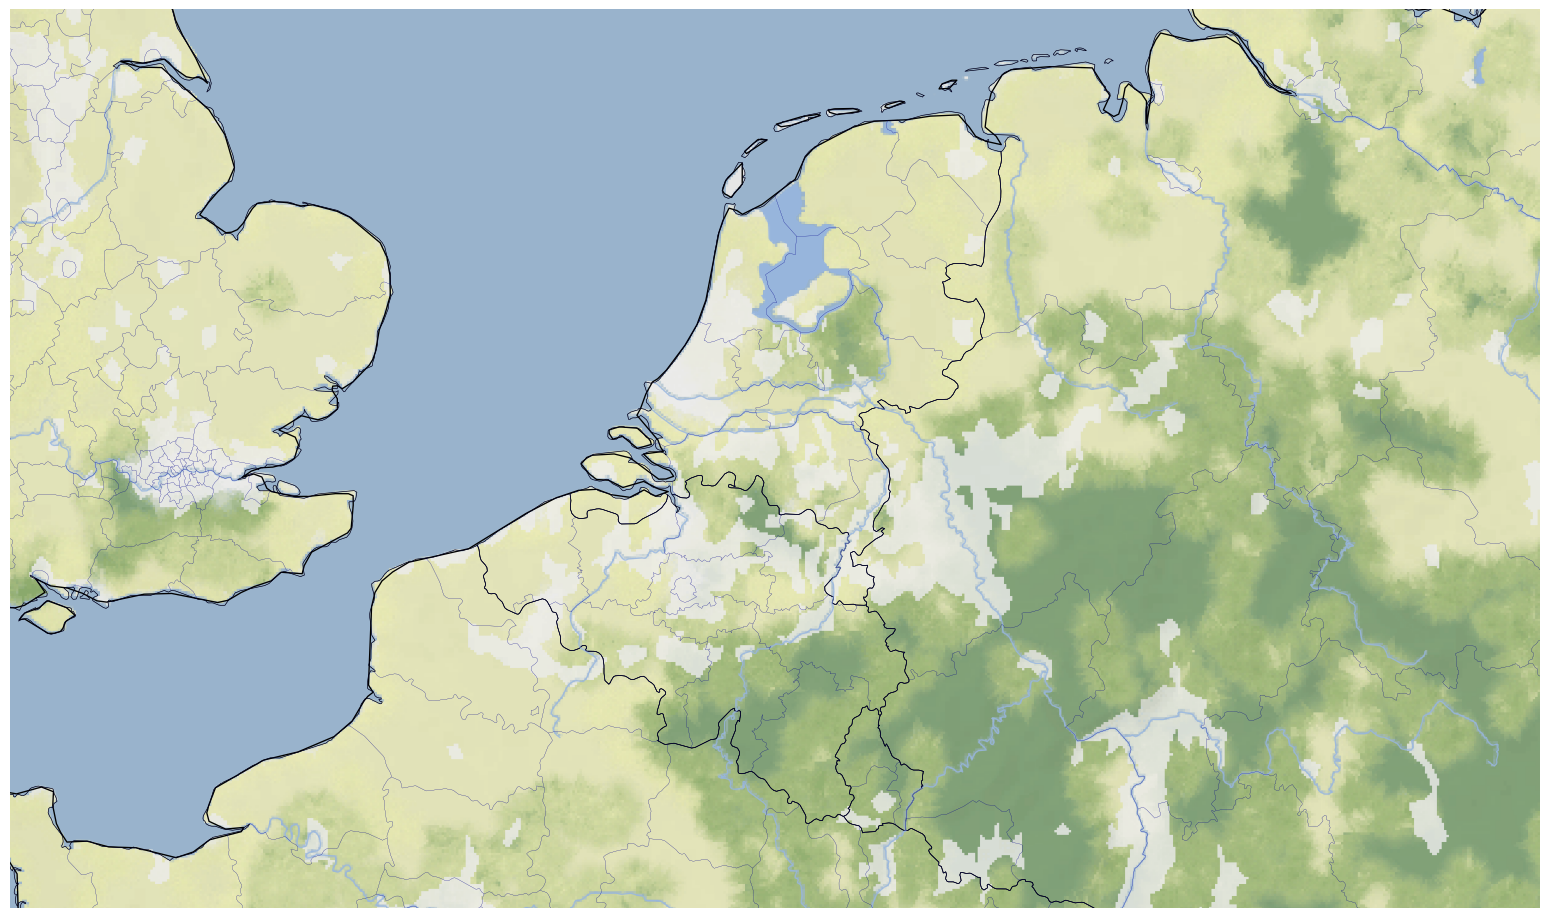

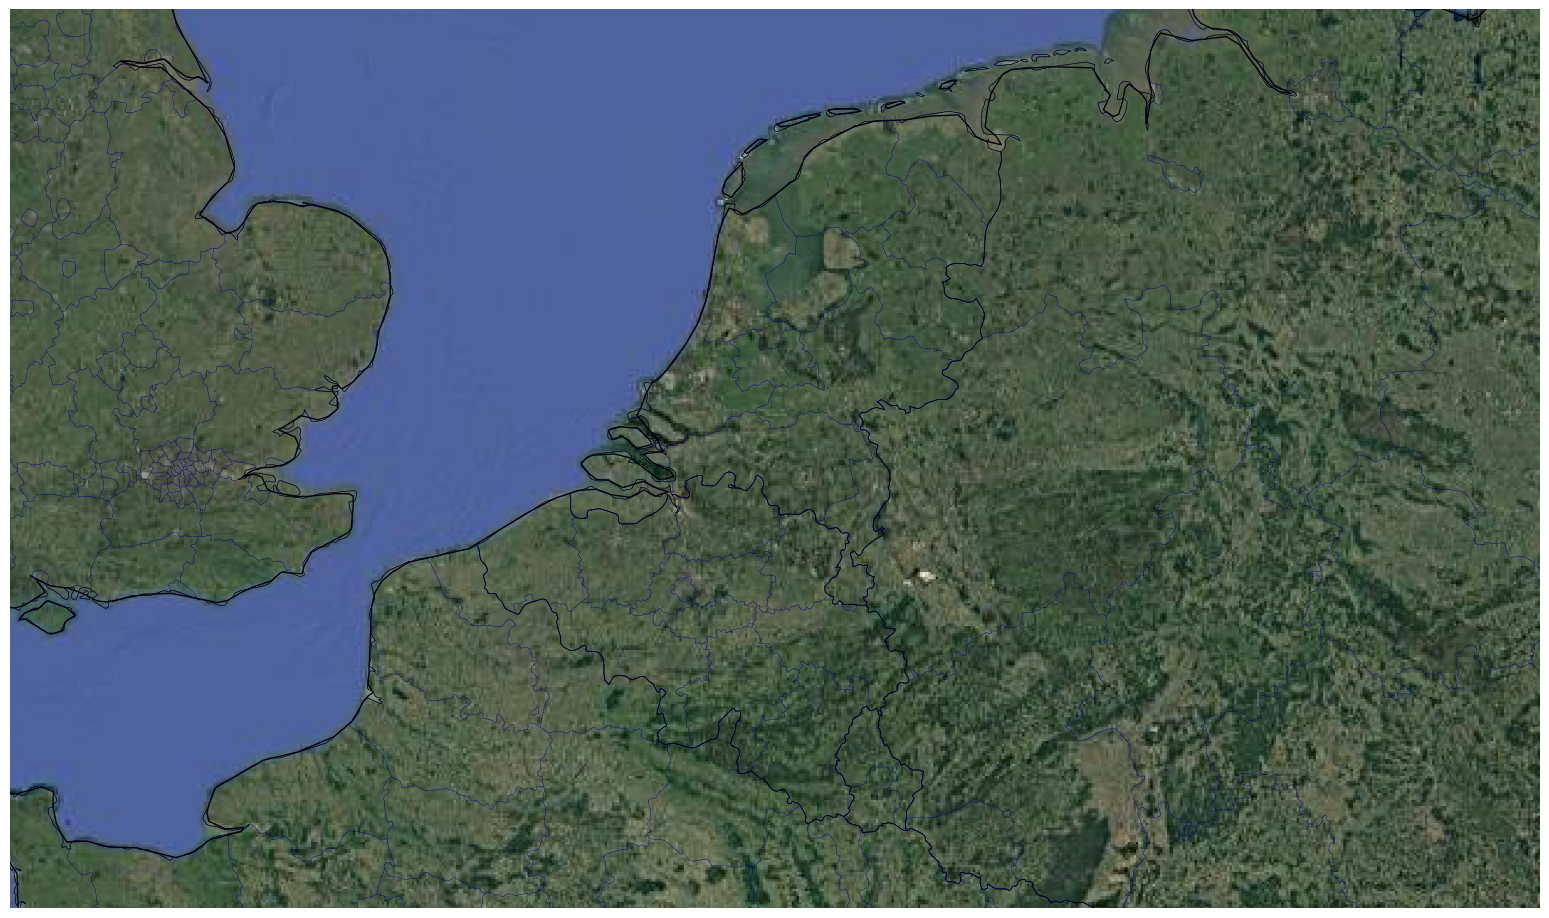

In [4]:
coords = [-1.65, 12, 49, 54]
name = "benelux"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1004x900 at 0x734E7BBD6A50>
dims ok?
False


TypeError: can only concatenate str (not "int") to str

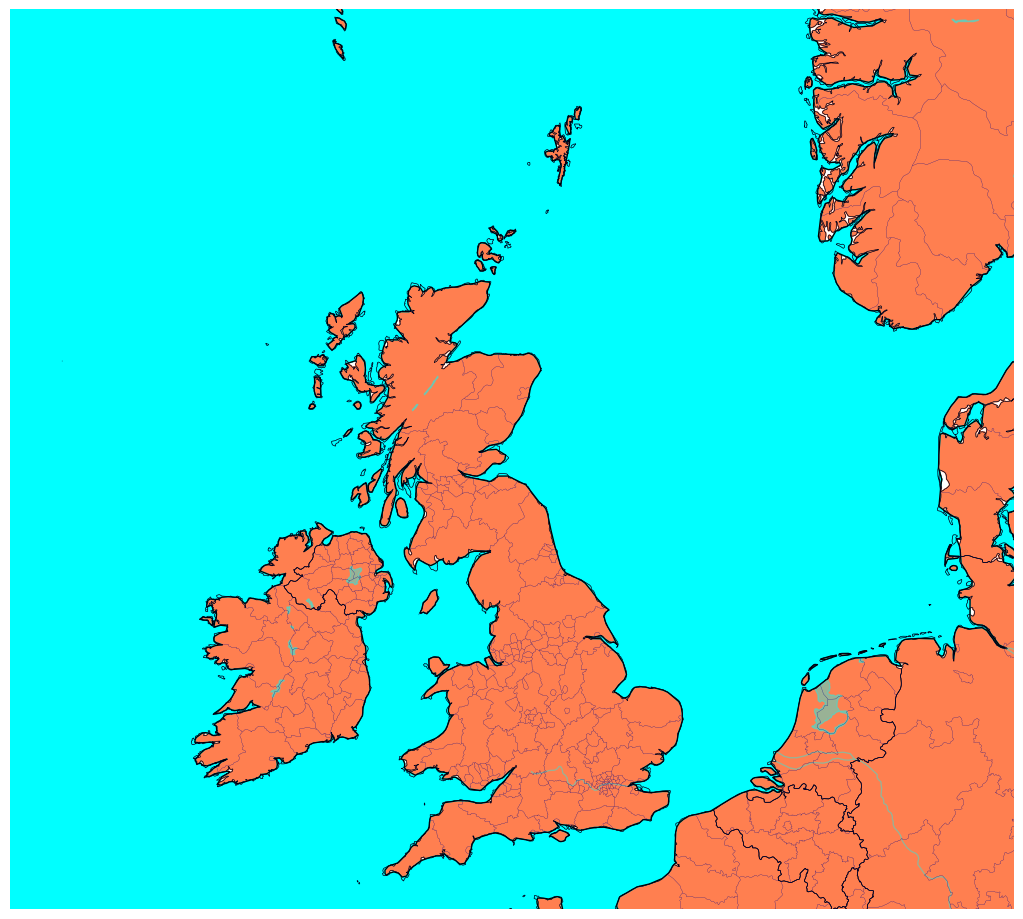

In [10]:
coords = [-15, 10, 49.5, 62]
name = "britishisles"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [32.65, 53, 28.5, 38.5]
name = "iraq"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [27, 38.335, -1.7, 5]
name = "uganda"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [15, 45, 7.5, 24.5]
name = "sudan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [94.5, 157, 20, 49.65]
name = "eastasia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [69, 98.62, 23, 38]
name = "himalayas"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [77, 152, -10.5, 32]
name = "indochina"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [78, 117, 8.5, 30.1]
name = "myanmar"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [19, 190, 31.5, 79]
name = "russia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [28, 53.85, 3, 18]
name = "ethiopia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [87, 116.65, 5, 22]
name = "thailand"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [24, 45, -12, 0.35]
name = "tanzania"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [84.03, 97, 20.5, 27.5]
name = "bangladesh"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [100.47, 110, 10, 15.5]
name = "cambodia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [0, 23.95, 1, 15]
name = "cameroon"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [9.189, 9.887, 47.02, 47.3]
name = "liechtenstein"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-3.9, 21.05, 11, 25]
name = "niger"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [2, 33.8, 7, 25]
name = "chad"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [11.78, 29, 2.1, 12.2]
name = "centralafricanrepublic"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-19, 11.37, 9.5, 26.5]
name = "mali"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-85.4, -64.5, 14.43, 26]
name = "greaterantilles"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-74, -56.47, 10, 20]
name = "lesserantilles"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [42.8, 90, 40, 58]
name = "kazakhstan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [68.6, 81, 38.5, 44]
name = "kyrgyzstan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [64.9, 78, 36, 42]
name = "tajikistan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [52, 78, 36, 47.41]
name = "uzbekistan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [50, 72, 34, 44.06]
name = "turkmenistan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-14.34, 0, 36.5, 43]
name = "portugal"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-90, -55.9, -5, 15]
name = "colombia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-79.3, -52, -1, 15]
name = "venezuela"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-69.1, -47, -29, -17]
name = "paraguay"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-61.98, -48, -35.5, -28.5]
name = "uruguay"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-79, -49.05, -24, -7]
name = "bolivia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [22, 48, 33.14, 45]
name = "turkey"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [56, 78.65, 29, 40]
name = "afghanistan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [105, 140, 2, 22.15]
name = "philippines"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [20, 30, 56.92, 60]
name = "estonia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [20, 30, 55.285, 58.5]
name = "latvia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [18.43, 28, 53.8, 57]
name = "lithuania"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [4, 12.66, 45, 48.5]
name = "switzerland"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [90, 120.1, 8, 25]
name = "vietnam"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [12.440, 12.4605, 41.899, 41.908]
name = "vaticancity"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [121, 135.75, 33, 40]
name = "southkorea"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [23.8, 63.5, 15, 36]
name = "saudiarabia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [151, 190.4, -49, -31.4]
name = "newzealand"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [52.25, 84, 23, 39]
name = "pakistan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-25, 10, 20.03, 38]
name = "morocco"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [3.53, 41, -14, 8]
name = "democraticrepublicofthecongo"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [9, 37, -35.51, -21]
name = "southafrica"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-2.48, 19, 3.5, 16]
name = "nigeria"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-84, -34.3, -19, 10]
name = "amazon"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-91.7, -17, -34, 8]
name = "brazil"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-120, -80, 13.61, 35]
name = "mexico"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [50, 107.3, 6, 37]
name = "india"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-2.1, 25.4, 36, 48]
name = "italy"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-19.55, 15, 49.5, 61]
name = "unitedkingdom"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-2.1, 23, 46.8, 56]
name = "germany"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-10.2, 17, 41, 52]
name = "france"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-130, -60, 22, 53.7]
name = "unitedstates"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [36, 72.6, 24, 42]
name = "iran"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [62, 148, 16.85, 56]
name = "china"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-14.18, 8, 35, 45]
name = "spain"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [84.5, 151, -23.5, 15]
name = "indonesia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [16.5, 41.7, 20.81, 34]
name = "egypt"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-92, -55, -19.5, 2]
name = "peru"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [17.4, 45.3, 43.18, 54]
name = "ukraine"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-102, -20, -56.5, -20]
name = "argentina"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [97, 170, -45.5, -8]
name = "australia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-152.1, -40, 38, 72.5]
name = "canada"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-25, 50, 52.2, 72]
name = "nordic"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [110, 164.5, 23.5, 49]
name = "japan"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [129, 270, -49, 26]
name = "polynesia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [5, 39, 34.15, 49.05]
name = "balkans"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [23.1, 68, 12, 36]
name = "arabia"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [28, 106, 23, 57]
name = "thestans"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [-19, 49.2, 6, 42]
name = "sahara"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [30, 49, 5.9, -5.33]
name = "kenya"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

In [ ]:
coords = [18.8, 33.7, 49, 42.9]
name = "romania"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)

# Antarctica

In [ ]:
coords = [-180, 180, -90, -55]
name = "antarctica"
ok = classic(coords, name)
if (ok):
    terrain(coords, name)
    satellite(coords, name)


# # Antarctica
# my_dpi=96
# f = plt.figure(figsize=(1530/my_dpi, 900/my_dpi), dpi=my_dpi, frameon=False)
# ax1 = plt.axes(projection=ccrs.SouthPolarStereo())

# # Limit the map to -60 degrees latitude and below.
# ax1.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

# ax1.add_feature(cartopy.feature.LAND)
# ax1.add_feature(cartopy.feature.OCEAN)

# ax1.gridlines()



# plt.show()

# Spinning Globe

In [ ]:
i = 0
for lon_viewing_angle in np.arange(-180, 180, 3):
        fig = plt.figure(figsize=(3,3))
        #print(lon_viewing_angle)
        # set perspective angle
        lat_viewing_angle = 40
        #lon_viewing_angle = -180

        # define color maps for water and land
        ocean_map = (plt.get_cmap('ocean'))(210)
        cmap = plt.get_cmap('gist_earth')

        # call the basemap and use orthographic projection at viewing angle
        m = Basemap(projection='ortho',
                  lat_0=lat_viewing_angle, lon_0=lon_viewing_angle)

        # coastlines, map boundary, fill continents/water, fill ocean, draw countries
        m.drawcoastlines()
        m.drawmapboundary(fill_color=ocean_map)
        m.fillcontinents(color='coral',lake_color=ocean_map)
#       m.drawcountries()

        # latitude/longitude line vectors
        lat_line_range = [-90,90]
        lat_lines = 8
        lat_line_count = (lat_line_range[1]-lat_line_range[0])/lat_lines

        merid_range = [-180,180]
        merid_lines = 8
        merid_count = (merid_range[1]-merid_range[0])/merid_lines

        m.drawparallels(np.arange(lat_line_range[0],lat_line_range[1],lat_line_count))
        m.drawmeridians(np.arange(merid_range[0],merid_range[1],merid_count))

        # save figure at 150 dpi and show it
        plt.savefig('globe_classic/view' + str(i).zfill(3) + '.png',dpi=150,transparent=True)
        plt.show()
        plt.clf()
        i = i + 1;


In [ ]:
from PIL import Image
import IPython.display as display
import os, math, time

max_frames_row = 1000
frames = []
tile_width = 0
tile_height = 0

spritesheet_width = 0
spritesheet_height = 0

files = os.listdir("globe/")
files.sort()
print(files)

for current_file in files :
    try:
        with Image.open("globe_classic/" + current_file) as im :
            frames.append(im.getdata())
    except:
        print(current_file + " is not a valid image")

tile_width = frames[0].size[0]
tile_height = frames[0].size[1]

if len(frames) > max_frames_row :
    spritesheet_width = tile_width * max_frames_row
    required_rows = math.ceil(len(frames)/max_frames_row)
    spritesheet_height = tile_height * required_rows
else:
    spritesheet_width = tile_width*len(frames)
    spritesheet_height = tile_height

print(spritesheet_height)
print(spritesheet_width)

spritesheet = Image.new("RGBA",(int(spritesheet_width), int(spritesheet_height)))

for current_frame in frames :
    top = tile_height * math.floor((frames.index(current_frame))/max_frames_row)
    left = tile_width * (frames.index(current_frame) % max_frames_row)
    bottom = top + tile_height
    right = left + tile_width

    box = (left,top,right,bottom)
    box = [int(i) for i in box]
    cut_frame = current_frame.crop((0,0,tile_width,tile_height))

    spritesheet.paste(cut_frame, box)

display.display(spritesheet)
spritesheet.save("spritesheet_classic.png", "PNG")


# Favicon

In [ ]:
lon_viewing_angle=0
fig = plt.figure(figsize=(0.32,0.32))
#print(lon_viewing_angle)
# set perspective angle
lat_viewing_angle = 40
#lon_viewing_angle = -180

# define color maps for water and land
ocean_map = (plt.get_cmap('ocean'))(210)
cmap = plt.get_cmap('gist_earth')

# call the basemap and use orthographic projection at viewing angle
m = Basemap(projection='ortho',
          lat_0=lat_viewing_angle, lon_0=lon_viewing_angle)

# coastlines, map boundary, fill continents/water, fill ocean, draw countries
#m.drawcoastlines()
m.drawmapboundary(fill_color=ocean_map)
m.fillcontinents(color=cmap(200),lake_color=ocean_map)
#m.drawcountries()

# latitude/longitude line vectors
lat_line_range = [-90,90]
lat_lines = 3
lat_line_count = (lat_line_range[1]-lat_line_range[0])/lat_lines

merid_range = [-180,180]
merid_lines = 3
merid_count = (merid_range[1]-merid_range[0])/merid_lines

#m.drawparallels(np.arange(lat_line_range[0],lat_line_range[1],lat_line_count))
#m.drawmeridians(np.arange(merid_range[0],merid_range[1],merid_count))

# save figure at 150 dpi and show it
plt.savefig('favicon.png',dpi=150,transparent=True)
plt.show()
plt.clf()


# OG Image

In [ ]:
lon_viewing_angle=0
fig = plt.figure(figsize=(5,5))
#print(lon_viewing_angle)
# set perspective angle
lat_viewing_angle = 40
#lon_viewing_angle = -180

# define color maps for water and land
ocean_map = (plt.get_cmap('ocean'))(210)
cmap = plt.get_cmap('gist_earth')

# call the basemap and use orthographic projection at viewing angle
m = Basemap(projection='ortho',
          lat_0=lat_viewing_angle, lon_0=lon_viewing_angle)

# coastlines, map boundary, fill continents/water, fill ocean, draw countries
#m.drawcoastlines()
m.drawmapboundary(fill_color=ocean_map)
m.fillcontinents(color=cmap(200),lake_color=ocean_map)
#m.drawcountries()

# latitude/longitude line vectors
lat_line_range = [-90,90]
lat_lines = 3
lat_line_count = (lat_line_range[1]-lat_line_range[0])/lat_lines

merid_range = [-180,180]
merid_lines = 3
merid_count = (merid_range[1]-merid_range[0])/merid_lines

#m.drawparallels(np.arange(lat_line_range[0],lat_line_range[1],lat_line_count))
#m.drawmeridians(np.arange(merid_range[0],merid_range[1],merid_count))

# save figure at 150 dpi and show it
plt.savefig('ogimage.png',dpi=500,transparent=True)
plt.show()
plt.clf()

# Spinning Globe Terrain

In [ ]:
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import os

import cartopy.io.img_tiles as cimgt

from matplotlib.image import imread
import numpy as np

stamen = True
start_angle = 81
i = int((start_angle + 180) / 3)
for lon_viewing_angle in np.arange(start_angle, 180, 3):
        print(lon_viewing_angle)

        plt.figure(figsize=(3,3), dpi=150, frameon=False)
#         plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0)

        ax = plt.axes(projection=ccrs.Orthographic(central_longitude=lon_viewing_angle, central_latitude=40))
        ax.set_axis_off()

        # land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor = 'none', facecolor = 'none')
        # ax.add_feature(land)

        coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='black',
                                                   facecolor='none')
        ax.add_feature(coastline)

        borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black',
                                                   facecolor='none')
        ax.add_feature(borders, linewidth = 0.5, linestyle='-')

#         dispute = cfeature.NaturalEarthFeature('cultural', 'admin_0_breakaway_disputed_areas', '50m', edgecolor='red',
#                                                    facecolor='none')
#         ax.add_feature(dispute, linewidth = 0.6, linestyle='-')

        # lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
        # ax.add_feature(lakes, alpha = 0.8)

        # rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m')
        # ax.add_feature(rivers, alpha = 0.8)

        ax.add_feature(cartopy.feature.RIVERS, alpha = 0.8)
        ax.add_feature(cartopy.feature.LAKES, alpha = 0.8)
        ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', linewidth=0.2, color='grey')

    #     ax.stock_img()
        if (stamen):
            # Create a Stamen terrain background instance.
            # terrain = cimgt.Stamen('terrain-background') #Stamen deprecated
            terrain = cimgt.StadiaMapsTiles('5ab59f82-18b0-4fba-88b2-3dd5f11c0f53', 'stamen_terrain_background')
        else:
            terrain = cimgt.GoogleTiles(style='satellite') # need cartopy 0.19 or 0.20 for cache=True)
        ax.add_image(terrain, 1)

        # save figure at 150 dpi and show it
        if (stamen): sfx = '_terrain'
        else: sfx = '_satellite'
        plt.savefig('globe' + sfx + '/view' + str(i).zfill(3) + '.png',dpi=150,transparent=True)
        plt.close()
#         plt.show()
#         plt.clf()
        i = i + 1;

from PIL import Image
import IPython.display as display
import os, math, time
max_frames_row = 1000
frames = []
tile_width = 0
tile_height = 0

spritesheet_width = 0
spritesheet_height = 0

files = os.listdir("globe/")
files.sort()
print(files)

for current_file in files :
    try:
        with Image.open("globe" + sfx + "/" + current_file) as im :
            frames.append(im.getdata())
    except:
        print(current_file + " is not a valid image")

tile_width = frames[0].size[0]
tile_height = frames[0].size[1]

if len(frames) > max_frames_row :
    spritesheet_width = tile_width * max_frames_row
    required_rows = math.ceil(len(frames)/max_frames_row)
    spritesheet_height = tile_height * required_rows
else:
    spritesheet_width = tile_width*len(frames)
    spritesheet_height = tile_height

print(spritesheet_height)
print(spritesheet_width)

spritesheet = Image.new("RGBA",(int(spritesheet_width), int(spritesheet_height)))

for current_frame in frames :
    top = tile_height * math.floor((frames.index(current_frame))/max_frames_row)
    left = tile_width * (frames.index(current_frame) % max_frames_row)
    bottom = top + tile_height
    right = left + tile_width

    box = (left,top,right,bottom)
    box = [int(i) for i in box]
    cut_frame = current_frame.crop((0,0,tile_width,tile_height))

    spritesheet.paste(cut_frame, box)

display.display(spritesheet)
spritesheet.save("spritesheet" + sfx + ".png", "PNG")


# Spinning Globe Satellite

In [ ]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import os

import cartopy.io.img_tiles as cimgt

from matplotlib.image import imread
import numpy as np

stamen = False
start_angle = 177
i = int((start_angle + 180) / 3)
for lon_viewing_angle in np.arange(start_angle, 180, 3):
        print(lon_viewing_angle)

        plt.figure(figsize=(3,3), dpi=150, frameon=False)
#         plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0)

        ax = plt.axes(projection=ccrs.Orthographic(central_longitude=lon_viewing_angle, central_latitude=40))
        ax.set_axis_off()

        # land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor = 'none', facecolor = 'none')
        # ax.add_feature(land)

        coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='black',
                                                   facecolor='none')
        ax.add_feature(coastline)

        borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black',
                                                   facecolor='none')
        ax.add_feature(borders, linewidth = 0.5, linestyle='-')

#         dispute = cfeature.NaturalEarthFeature('cultural', 'admin_0_breakaway_disputed_areas', '50m', edgecolor='red',
#                                                    facecolor='none')
#         ax.add_feature(dispute, linewidth = 0.6, linestyle='-')

        # lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
        # ax.add_feature(lakes, alpha = 0.8)

        # rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m')
        # ax.add_feature(rivers, alpha = 0.8)

#         ax.add_feature(cartopy.feature.RIVERS, alpha = 0.8)
#         ax.add_feature(cartopy.feature.LAKES, alpha = 0.8)
        ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', linewidth=0.2, color='grey')

    #     ax.stock_img()
        if (stamen):
            # Create a Stamen terrain background instance.
            # terrain = cimgt.Stamen('terrain-background') # deprecated
            terrain =  cimgt.StadiaMapsTiles('5ab59f82-18b0-4fba-88b2-3dd5f11c0f53', 'stamen_terrain_background')
        else:
            terrain = cimgt.GoogleTiles(style='satellite') # need cartopy 0.19 or 0.20 for cache=True)
        ax.add_image(terrain, 1)

        # save figure at 150 dpi and show it
        if (stamen): sfx = '_terrain'
        else: sfx = '_satellite'
        plt.savefig('globe' + sfx + '/view' + str(i).zfill(3) + '.png',dpi=150,transparent=True)
        plt.close()
#         plt.show()
#         plt.clf()
        i = i + 1;

from PIL import Image
import IPython.display as display
import os, math, time
max_frames_row = 1000
frames = []
tile_width = 0
tile_height = 0

spritesheet_width = 0
spritesheet_height = 0

files = os.listdir("globe/")
files.sort()
print(files)

for current_file in files :
    try:
        with Image.open("globe" + sfx + "/" + current_file) as im :
            frames.append(im.getdata())
    except:
        print(current_file + " is not a valid image")

tile_width = frames[0].size[0]
tile_height = frames[0].size[1]

if len(frames) > max_frames_row :
    spritesheet_width = tile_width * max_frames_row
    required_rows = math.ceil(len(frames)/max_frames_row)
    spritesheet_height = tile_height * required_rows
else:
    spritesheet_width = tile_width*len(frames)
    spritesheet_height = tile_height

print(spritesheet_height)
print(spritesheet_width)

spritesheet = Image.new("RGBA",(int(spritesheet_width), int(spritesheet_height)))

for current_frame in frames :
    top = tile_height * math.floor((frames.index(current_frame))/max_frames_row)
    left = tile_width * (frames.index(current_frame) % max_frames_row)
    bottom = top + tile_height
    right = left + tile_width

    box = (left,top,right,bottom)
    box = [int(i) for i in box]
    cut_frame = current_frame.crop((0,0,tile_width,tile_height))

    spritesheet.paste(cut_frame, box)

display.display(spritesheet)
spritesheet.save("spritesheet" + sfx + ".png", "PNG")


In [ ]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import os
%matplotlib inline
import matplotlib.pyplot as plt

import cartopy.io.img_tiles as cimgt

from matplotlib.image import imread

my_dpi = 96
plt.figure(figsize=(1530/my_dpi, 900/my_dpi), dpi=my_dpi, frameon=False)
plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0)

ax = plt.axes(projection=ccrs.Mercator(central_longitude=0))
ax.set_axis_off()

# land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor = 'none', facecolor = 'none')
# ax.add_feature(land)

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='black',
                                           facecolor='none')
ax.add_feature(coastline)

borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black',
                                           facecolor='none')
ax.add_feature(borders, linewidth = 0.5, linestyle='-')

dispute = cfeature.NaturalEarthFeature('cultural', 'admin_0_breakaway_disputed_areas', '50m', edgecolor='red',
                                           facecolor='none')
ax.add_feature(dispute, linewidth = 0.6, linestyle='-')

terrain = cimgt.GoogleTiles(style='satellite') # need cartopy 0.19 or 0.20 for cache=True)
ax.add_image(terrain, 2)
plt.show()

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix}  -c conda-forge gmplot

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


def main():
    # Create a Stamen Terrain instance.
    #stamen_terrain = cimgt.StamenTerrain()
    stamen_terrain = cimgt.GoogleTiles(style='satellite')

    # Create a GeoAxes in the tile's projection.
    ax = plt.axes(projection=stamen_terrain.crs)

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([0, 1, 0, 1])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 6)

    # Add a marker for the Eyjafjallajökull volcano.
    plt.plot(-19.613333, 63.62, marker='o', color='red', markersize=12,
             alpha=0.7, transform=ccrs.Geodetic())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    geodetic_transform = ccrs.Geodetic()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=-25)

    plt.show()


if __name__ == '__main__':
    main()